# Practical work 4: Frequency filtering, color

**Hugo Riffaud de Turckheim : 3800256**
**Charline Curaut : 3810013**


In [1]:
import numpy as np
from numpy.fft import fft2,ifft2,fftshift
import matplotlib.pyplot as plt
from PIL import Image
import os
import imageio
from scipy import signal
from matplotlib import cm

def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))

def imshow(I,title=None,size=500):
    """ display an image with a specific size """
    plt.figure(figsize=(size//80,size//80))
    plt.gray()
    plt.imshow(I)
    if title: plt.title(title)
    plt.show()

def surf(Z,title=None):
    """ 3D plot of an image """
    X,Y = np.meshgrid(range(Z.shape[1]), range(Z.shape[0]))
    fig = plt.figure(figsize=(600/80,600/80))
    if title: plt.title(title)
    ax = plt.subplot(projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.show()
    


## Exercice 1 - Frequency filtering

1. Compute than display the centered module of Fourier transform of `img/mandrill.png` (use functions seen in previous lessons). 

Text(0.5, 1.0, 'FFT')

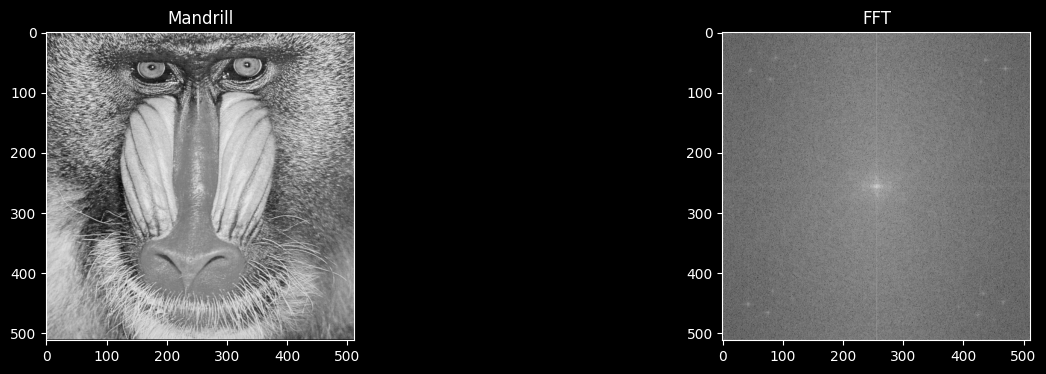

In [2]:
singe = np.array(Image.open('img/mandrill.png'))
lena = np.array(Image.open('img/lena.jpg'))
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(singe,cmap="gray")
ax.set_title("Mandrill")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(singe)))),cmap="gray")
ax.set_title('FFT')

2. Write a function `idealLowPassFilter(n,m,fc)` returning an ideal low pass filter with frequency cutoff $f_c$ and size $n\times m$. Recall: this function set to 1 pixels at Euclidian distance $f_c$ from the center (null frequency).

In [3]:
def idealLowPassFilter(n,m,fc) :
    centreX = int(n/2.0)
    centreY = int(m/2.0)
    H = np.zeros((n,m))
    for i in range(n) :
        for j in range(m) :
            
            if np.sqrt((i-centreX)**2+(j-centreY)**2) <= fc :
                
                H[i][j] = 1
    
    return H

3. Write a function `lowPass(I,fc)` performing a low pass filtering of an image $I$. The function should
 - compute the centered Fourier transform of $I$
 - multiply point-by-point the spectrum with the ideal low filter produced by `idealLowPassFilter()`
 - uncenter the filtered spectrum and apply the inverse Fourier transform (use function `ifft2()` from module `numpy.fft`)
 - return the real part of filtered image

In [3]:
def lowPass(I,fc) :
    ftI = np.fft.fftshift(np.fft.fft2(I))
    filtre = idealLowPassFilter(I.shape[0], I.shape[1], fc)
    mult = filtre * ftI

    return np.real(np.fft.ifft2(np.fft.fftshift(mult)))
    

4. Experiment this function on `img/mandrill.png` and `img/lena.jpg` with various values of cut off $f_c$.
 - give two effects that appears when $f_c$ decreases,
 - propose two applications of this filtering.


on va créer une fonction PSNR pour mesurer la perte d'information présente sur l'image après filtrage

In [4]:
def PSNR(I1,I2):
    R = 255
    return 10 * np.log10(R**2 / (np.linalg.norm(I2-I1, ord=2)/(I1.shape[0]*I1.shape[1])) )

In [6]:
def lowPassFiltering(I,fc) :
    filtered_pic = lowPass(I, fc)
    fig = plt.figure(figsize=plt.figaspect(0.5))
        
    ax = fig.add_subplot(1, 4, 1)
    ax.imshow(I,cmap="gray")
    ax.set_title("original")
        
    ax = fig.add_subplot(1, 4, 2)
    ax.imshow(idealLowPassFilter(512,512,fc),cmap="gray")
    ax.set_title('filter')
        
    ax = fig.add_subplot(1, 4, 3)
    ax.imshow(filtered_pic,cmap="gray")
    ax.set_title('filtered image')
        
    ax = fig.add_subplot(1, 4, 4)
    ax.imshow(np.abs(I-filtered_pic),cmap="gray")
    ax.set_title('PSNR: '+ str(np.around(PSNR(I,filtered_pic),2))+" dB")

In [5]:
nb_pass=400

def lowPassFilteringMult(I,fc,nb_pass):
    tmp_arr=np.linspace(10,fc,nb_pass).astype(int)

    for i in tmp_arr:
        lowPassFiltering(I,i)
        #txt ='PSNR: '+ str(np.around(PSNR(singe,filtered_pic),2))+" dB"
        #plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

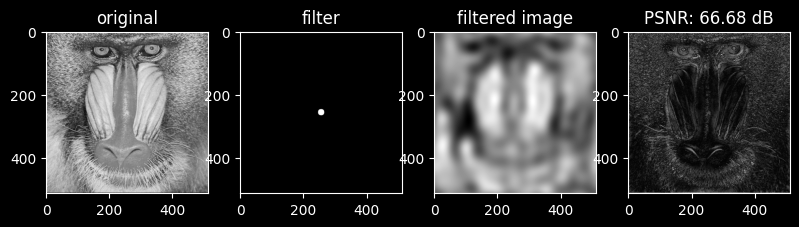

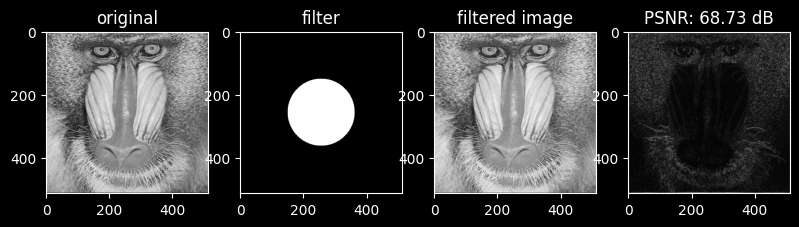

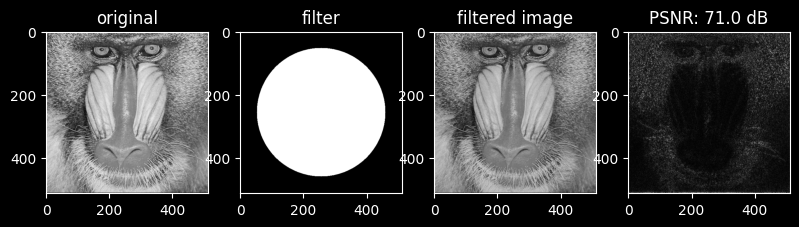

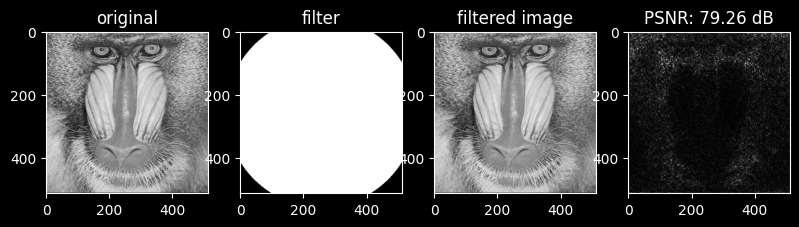

In [8]:
lowPassFilteringMult(singe, 300, 4)

Plus le filtre est petit (fc diminue), plus l'image est flou, de mauvaise qualité. Grâce au PSNR, on voit qu'on perd de plus en plus d'information.
L'image à droite de chaque figure est la différence entre l'original et le filtre. On voit bien que plus le filtre est grand et plus l'information perdue est détaillée.

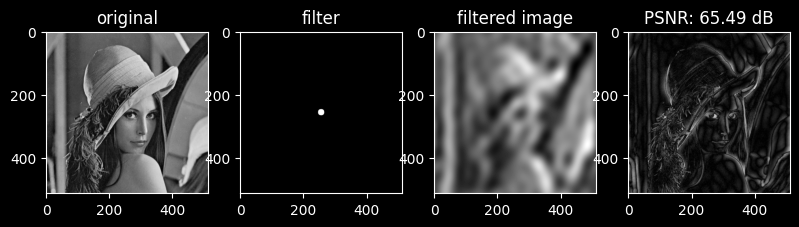

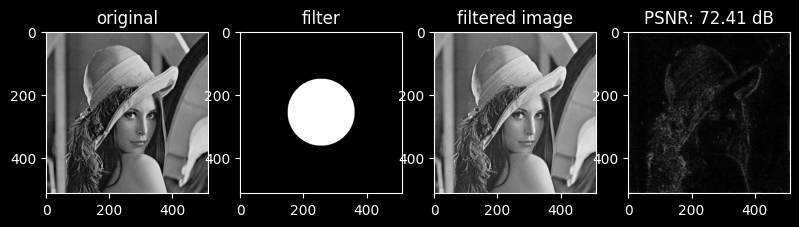

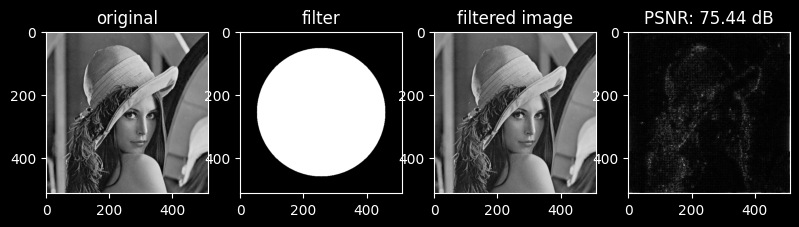

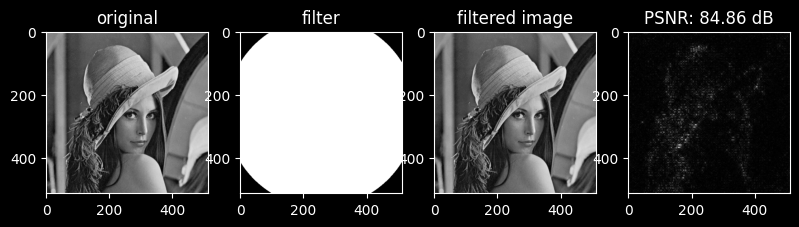

In [9]:
lowPassFilteringMult(lena, 300, 4)

## Exercice 2 -  Linear filtering (convolution)

1. Given a kernel convolution of size $d\times d$, $d$ being odd. How many lines and columns should be added to each side of the image to apply this filter? The image is supposed surrounded by zero values.

Le filtre est de taille d*d. Si on centre le filtre sur le pixel p en haut à droite de l'image, il faut avoir autant de pixels du filtre d'un côté ou de l'autre du pixel p, soit (d-1)/2 de chaque côté. Donc il faut rajouter (d-1)/2 lignes et colonnes de chaque côté de l'image.

2. Write a function `imagePad(I,h)` getting an image and a kernel, returning a new image padded with zeros according to question 1. It is not allowed to use a module implementing the padding.

In [6]:
def imagePad(I,h) :
    nb = int((max(h.shape[0],h.shape[1]) - 1) / 2.0)
    mat1 = np.hstack((np.zeros((I.shape[0], nb)), I, np.zeros((I.shape[0], nb))))
    mat2 = np.vstack((np.zeros((nb, mat1.shape[1])), mat1, np.zeros((nb, mat1.shape[1]))))
    return mat2

dimensions :  (512, 512)  et  (540, 540)


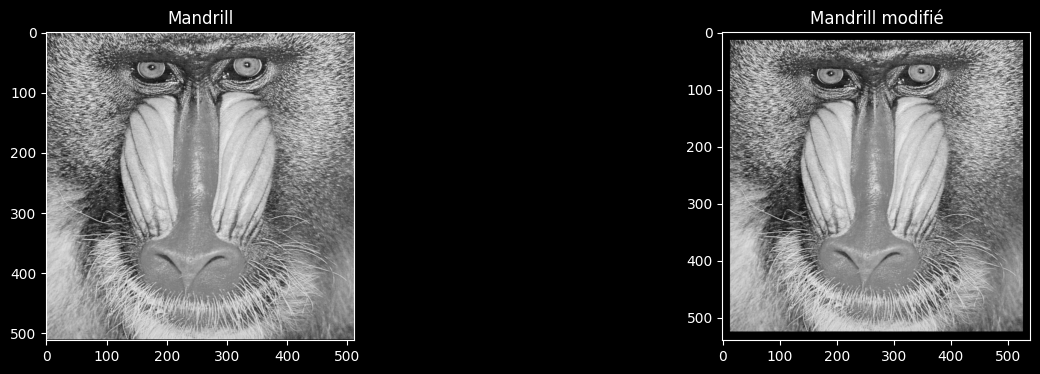

In [7]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(singe,cmap="gray")
ax.set_title("Mandrill")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(imagePad(singe,np.zeros((30,30))),cmap="gray")
ax.set_title("Mandrill modifié")

print("dimensions : ", singe.shape," et ", imagePad(singe,np.zeros((30,30))).shape)

3. Write a function `conv2(I,h)` getting an image and a kernel and returning the convolution of $I$ by $h$. The function should return an image having the same shape than $I$. It is not allowed to use a module implementing the convolution.

In [8]:
def conv2(I,h) :

    if (h.shape[0] % 2 == 0) or (h.shape[1] % 2 == 0) :
        raise ValueError("h must have odd dimensions")
        
    res = imagePad(I.copy(),h)
    
    n = int((h.shape[0]-1)/2.0)
    for i in range(n,I.shape[0]+n):
        for j in range(n,I.shape[1]+n):
            res[i][j]=np.mean(res[i-n:i+n+1,j-n:j+n+1]*h)
    return res[n:-n,n:-n]
        

4. Try this function on mean filter of size $3\times3$, $5\times 5$ and $7\times 7$. Discuss the results.

Text(0.5, 1.0, 'Mandrill modifié')

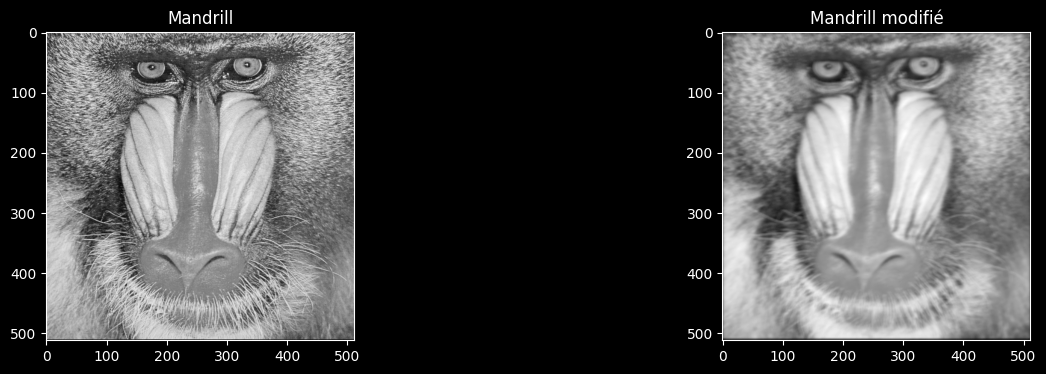

In [9]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(singe,cmap="gray")
ax.set_title("Mandrill")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(conv2(singe,np.ones((7,7))),cmap="gray")
ax.set_title("Mandrill modifié")


In [14]:
display_gif("smoothing_test.gif")

Le filtre qu'on applique attribue à chaque pixel la valeur moyenne de son voisinage. Cela se traduit par un "applatissement" des écarts entre les valeurs des pixels voisins.
Plus le filtre est grand et plus la valeur initiale de chaque pixel est perdu au profit des autres pixels (puisque le poids de chaque pixel vaut $1/n^2$ n la taille du filtre. ).


On peut observer l'applatissement des écarts de valeur entre les pixels de l'image en mesurant l'écart-type de l'image:
$$\sigma_{singe}=42.30$$
$$\sigma_{singe(3\cdot3)}=36.50$$
$$\sigma_{singe(5\cdot5)}=34.82$$
$$\sigma_{singe(7\cdot7)}=33.95$$
$$\sigma_{singe(513\cdot513)}=16.98$$

5. Display the transfert function of these mean filters. For a better visualization, use the zero-padding technique to obtain a filter with a large size (for instance $256\times 256$). Use `imshow()` and `toVisualizeLogFT()`.

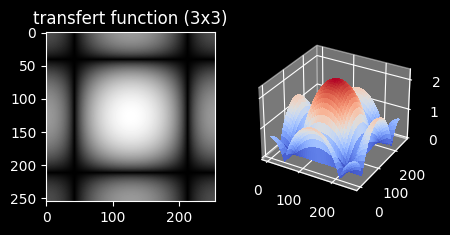

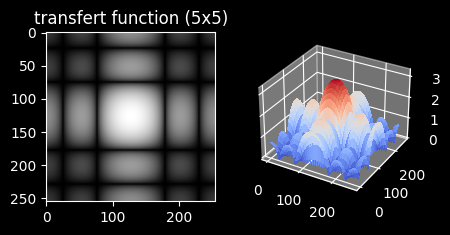

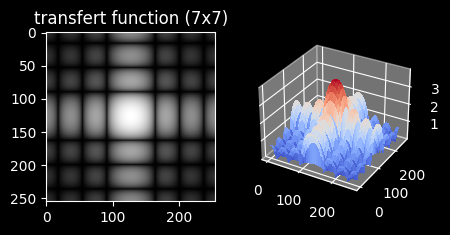

In [15]:
def display_transfert(size):
    fig = plt.figure(figsize=plt.figaspect(1.))
    ax = fig.add_subplot(1, 2, 1)
    kernel_size=3
    F=np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(imagePad(np.ones((size,size)),np.zeros((256-size,256-size)))))))
    ax.imshow(F,cmap="gray")
    ax.set_title("transfert function ("+str(size)+"x"+str(size)+")")

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    X,Y = np.meshgrid(range(F.shape[1]), range(F.shape[0]))  
    ax.plot_surface(X, Y, F, linewidth=0,cmap=cm.coolwarm, antialiased=False)


display_transfert(3)
display_transfert(5)
display_transfert(7)



6. Interpretation: what is the analytic expression of the transfert function of a mean filter? Is  it an ideal low pass filter?

La fonction de transfert est un sinus cardinal en 2D. Ce n'est pas un filtre idéal car les coefficients de H ne sont pas seulement égaux à 1 ou 0.

7. Bonus question: perform the same study for the Gaussian kernel. Determine $\sigma$ in order to have filter of size $3\times3$, $5\times5$, and $7\times7$.

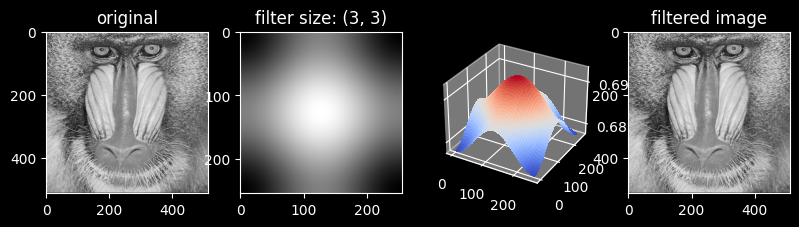

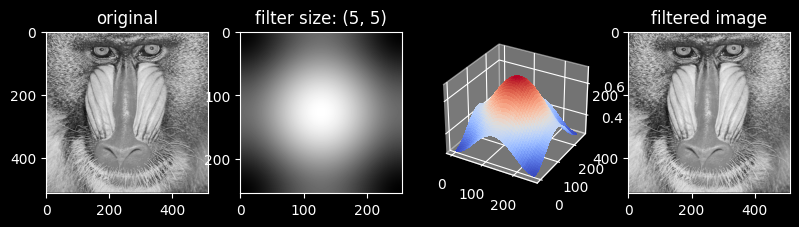

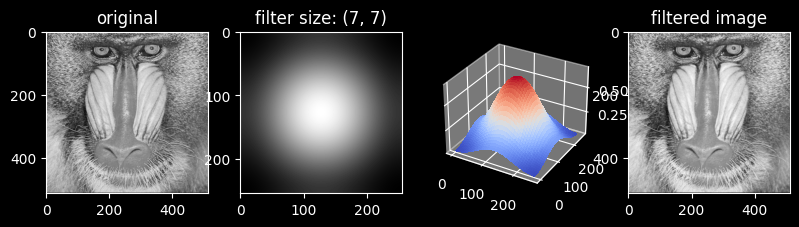

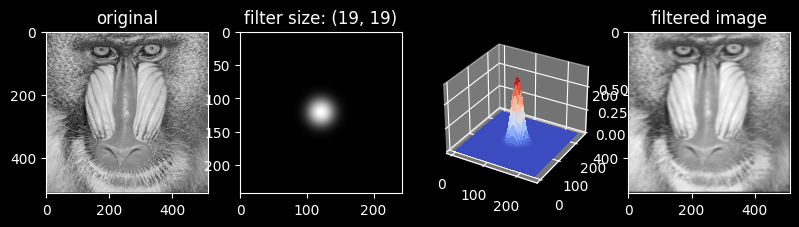

In [16]:
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def GaussianKernelFiltering(I,sigma) :
    filtered_pic = conv2(I.copy(),gaussianKernel(sigma))
    fig = plt.figure(figsize=plt.figaspect(.5))
        
    ax = fig.add_subplot(1, 4, 1)
    ax.imshow(I,cmap="gray")
    ax.set_title("original")
        
    ax = fig.add_subplot(1, 4, 2)
    F=np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(imagePad(gaussianKernel(sigma),np.zeros((256-int(sigma*10),256-int(sigma*10))))))))
    ax.imshow(F,cmap="gray")
    ax.set_title('filter size: '+str(gaussianKernel(sigma).shape))

    
    F=np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(imagePad(gaussianKernel(sigma),np.zeros((256-int(sigma*10),256-int(sigma*10))))))))
    
    ax = fig.add_subplot(1, 4, 3, projection='3d')
    X,Y = np.meshgrid(range(F.shape[1]), range(F.shape[0]))  
    ax.plot_surface(X, Y, F, linewidth=0,cmap=cm.coolwarm, antialiased=False)
        
    ax = fig.add_subplot(1, 4, 4)
    ax.imshow(filtered_pic,cmap="gray")
    ax.set_title('filtered image')
        

GaussianKernelFiltering(singe,0.3)
GaussianKernelFiltering(singe,0.5)
GaussianKernelFiltering(singe,0.7)
GaussianKernelFiltering(singe,3)


La fonction de transfert est une gaussienne en 2D. Ce n'est pas un filtre idéal car les coefficients de H ne sont pas seulement égaux à 1 ou 0.

In [17]:
display_gif("gaussian.gif")

## Exercice 3: anti aliasing filtering

1. Give a code that subsamples of factor 2 (use function `subSample2()` given in TME3) the image `img/barbara.png`.

In [18]:
def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]

Text(0.5, 1.0, 'subsampled 2 ')

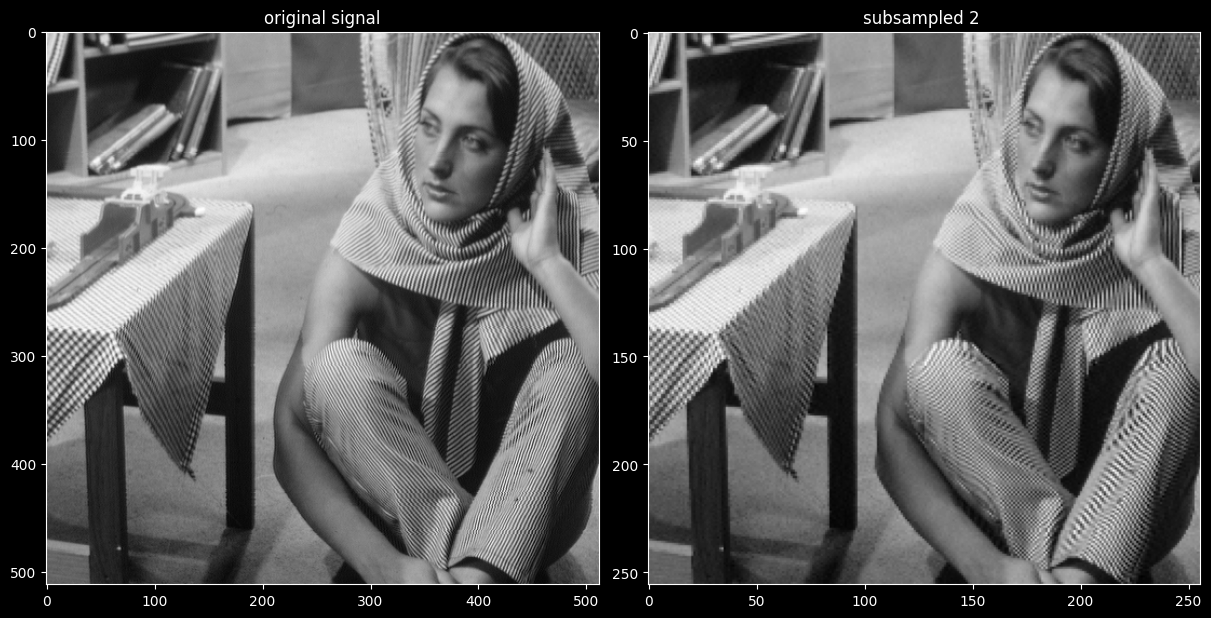

In [19]:
from PIL import Image

barbara = np.array(Image.open('img/barbara.png'))

axs = (plt.figure(constrained_layout=True,figsize=(1000//80,1000//80))
       .subplots(1, 2, sharex=False, sharey=False))
axs[0].imshow(barbara ,cmap="gray")
axs[0].set_title('original signal')
axs[1].imshow(subSample2(barbara),cmap="gray")
axs[1].set_title('subsampled 2 ')

2. Give a code that subsamples of factor 2 (use function `subSample2()`) the image `img/barbara.png` after applying an low pass filter (use `antiAliasingFilter()`). As comment, recall the principle of filtering in the frequency domain.

Principe : 
- On part de la transformée de Fourrier X du signal x
- On crée la fonction de transfert H qui est la tranformé de Fourrier du filtre h
- On ajuste X et H pour qu'ils aient la même taille
- On multiplie élément par élément X par H
- On applique la transfromée de Fourrier inverse sur le résultat de cette multiplication pour reconstruire un signal x' modifié

In [26]:
def antiAliasingFilter(n,m):
    """ int*int -> Array """
    n2, m2 = n//2, m//2
    rn, rm = n//4, m//4
    A = np.zeros((n, m))
    A[rn:rn+n2, rm:rm+m2] = 1
    return A
### your answer start below


In [27]:
def lowPass2(I) :
    ftI = np.fft.fftshift(np.fft.fft2(I))
    filtre = antiAliasingFilter(I.shape[0], I.shape[1])
    mult = filtre * ftI

    return np.real(np.fft.ifft2(np.fft.fftshift(mult)))

Text(0.5, 1.0, 'subsampled 2 with low pass filter')

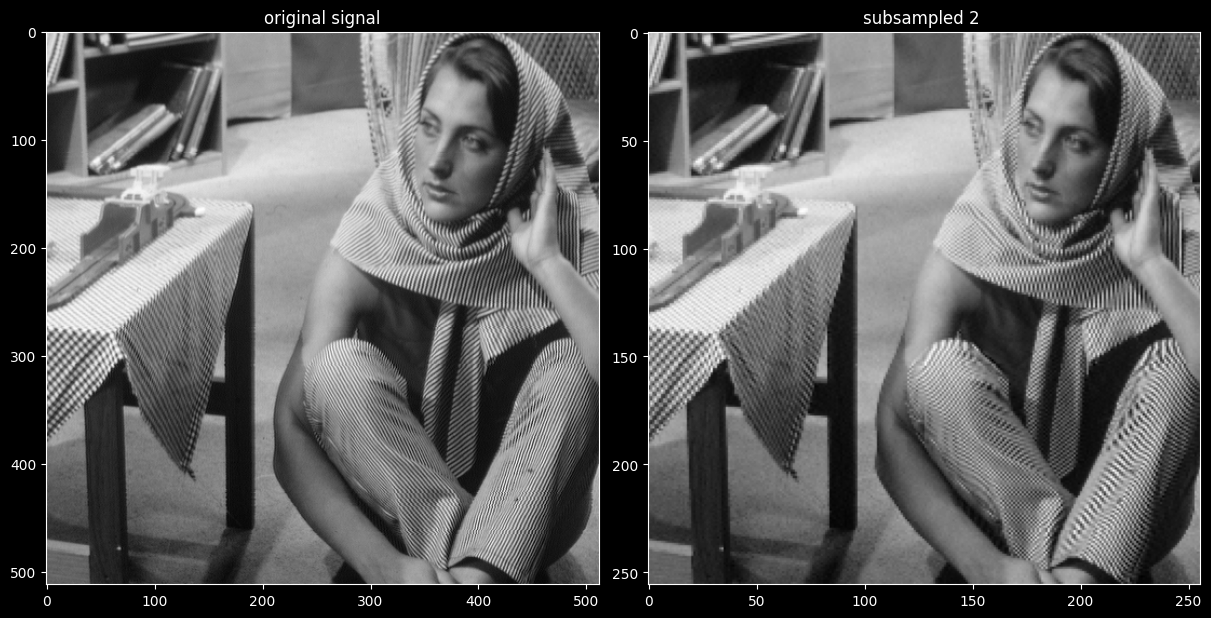

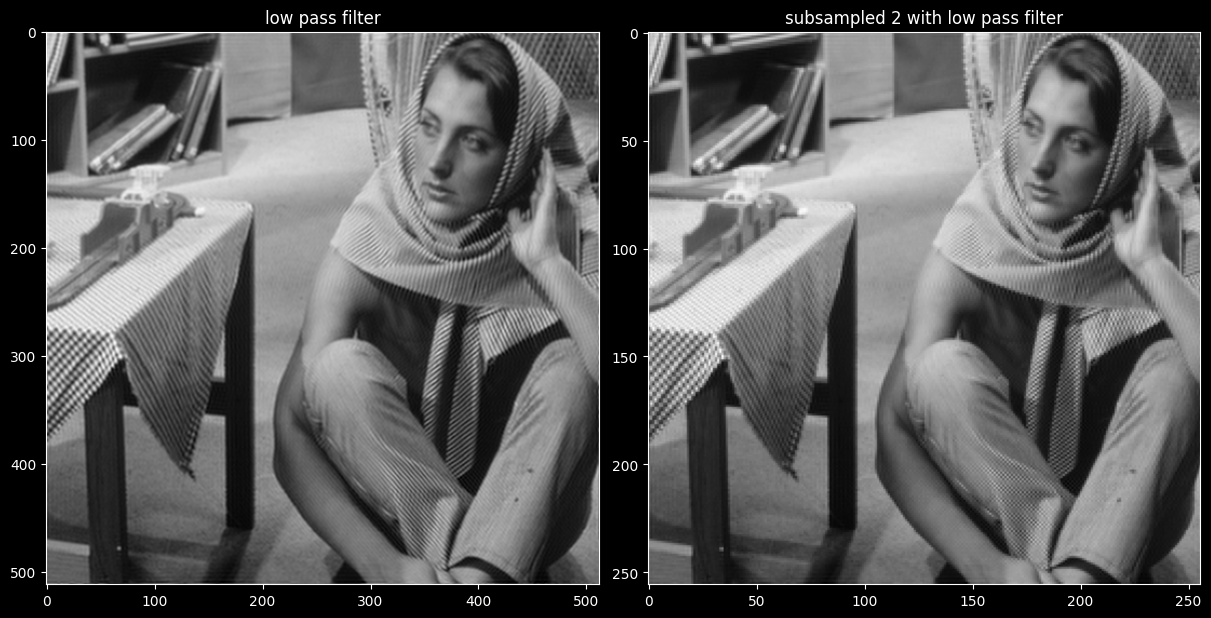

In [28]:
axs = (plt.figure(constrained_layout=True,figsize=(1000//80,1000//80))
       .subplots(1, 2, sharex=False, sharey=False))
axs[0].imshow(barbara ,cmap="gray")
axs[0].set_title('original signal')
axs[1].imshow(subSample2(barbara),cmap="gray")
axs[1].set_title('subsampled 2 ')

axs1 = (plt.figure(constrained_layout=True,figsize=(1000//80,1000//80))
       .subplots(1, 2, sharex=False, sharey=False))
axs1[0].imshow(lowPass2(barbara), cmap="gray")
axs1[0].set_title('low pass filter')
axs1[1].imshow(subSample2(lowPass2(barbara)),cmap="gray")
axs1[1].set_title('subsampled 2 with low pass filter')

3. Describe and analyze the filtering of Barbara with and without the anti aliasing filter. What information is lost for the two filtered images ?

Il n'y a quaisment aucunes différences visibles entre les deux images filtrées (sous-échatillonnage ou pas). Cependant, elles ont perdu les valeurs de hautes fréquences, le résultat est un peu lissé, on a perdu en netteté.

## Exercice 4: color image
1. Read images `img/clown.bmp` and `img/clown_lumi.bmp` as two arrays named $I_1$ and $I_2$. Display these images examine their shape. What difference there are between them?

Text(0.5, 1.0, 'shape : (512, 512, 3)')

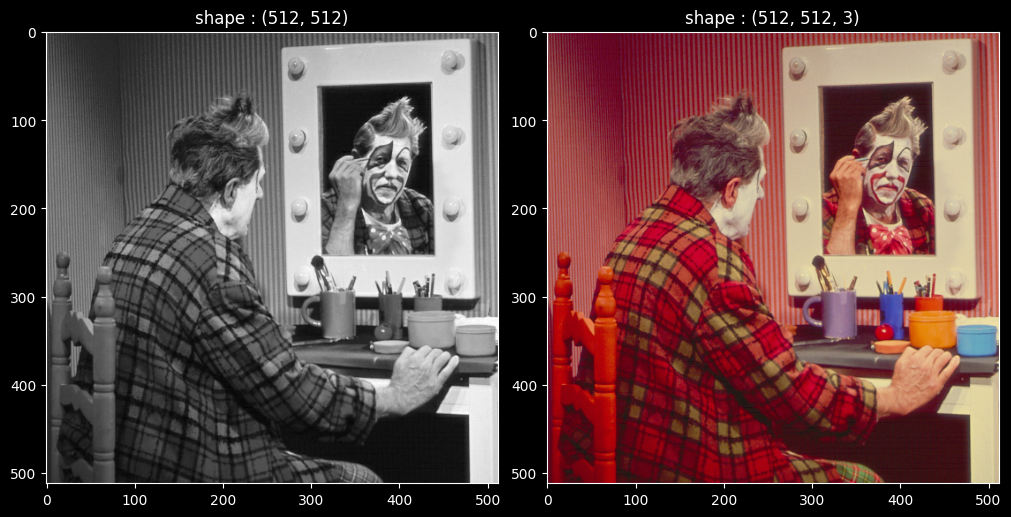

In [68]:
clown_nb = np.array(Image.open('img/clown_lumi.bmp'))
clown = np.array(Image.open('img/clown.bmp'))
w,h=400,400
axs = (plt.figure(constrained_layout=True,figsize=(w/40,h/80))
       .subplots(1, 2))
axs[0].imshow(clown_nb,cmap="gray")
axs[0].set_title('shape : '+str(clown_nb.shape))
axs[1].imshow(clown)
axs[1].set_title('shape : '+str(clown.shape))

2. The first image is an array of dimension 3. Explain the signification of each dimension. From this image create 3 images $I_R$, $I_G$, $I_B$ of dimension 2. Display these three images and explain what you see.

Chaque dimension correspond à un canal Red, Green, Blue. Chaque couleur du spectre visibile est composé d'une combinaison d'intensités de ces trois couleurs.

Text(0.5, 1.0, 'B')

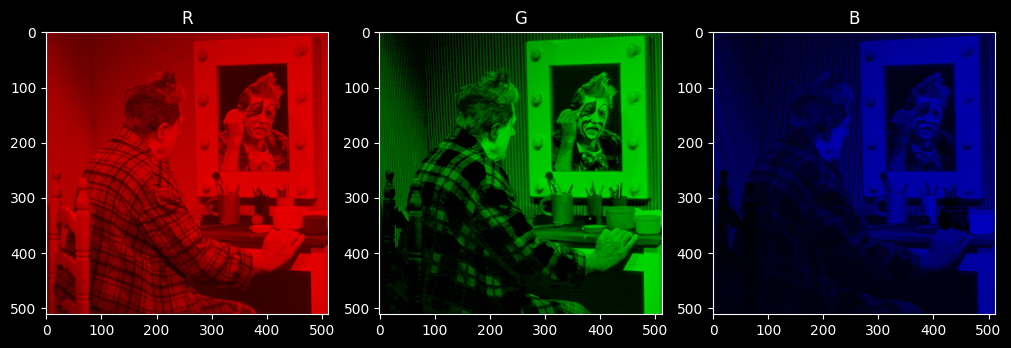

In [70]:

Ig=clown.copy()
Ir=clown.copy()
Ib=clown.copy()

Ir[:,:,1]=0
Ir[:,:,2]=0
Ir=Ir/255.0

Ig[:,:,0]=0
Ig[:,:,2]=0
Ig=Ig/255.0

Ib[:,:,0]=0
Ib[:,:,1]=0
Ib=Ib/255.0

axs = (plt.figure(constrained_layout=True,figsize=(w/40,h/80))
       .subplots(1, 3))
axs[0].imshow(Ir)


axs[0].set_title('R')
axs[1].imshow(Ig)
axs[1].set_title('G')
axs[2].imshow(Ib)
axs[2].set_title('B')


3. Create a new image $I_3$ of dimensions 3, the first dimension contains the value of $I_R$, the second the value of $I_B$ and the third the values of $I_G$. Try another combinations. Remark: color images are better handled by `imshow()` if pixel values range in $[0,1]$.

In [11]:
def influence_color(I,r,g,b):
    res=I.copy()
    res[:,:,0]=res[:,:,0]*r
    res[:,:,1]=res[:,:,1]*g
    res[:,:,2]=res[:,:,2]*b
    return res



display_gif("color_v2.gif")

On fait varier les valeurs des canaux RGB en fonction du temps

4. Write a code that allows the see the first channel with red color scales, the second channel in green color scales, and the blue channel in blue color scales.

voir la réponse de la question 1.

# Template Matching

Précédemment nous avons vu que la convolution consistait à faire glisser une fenêtre sur l'image d'origine afin de changer la valeur de chaque pixel en fonction de son voisinage.
Les valeurs sur cette fenêtre correspondaient à des poids dans le calcul de la moyenne du voisinage.

Dans la partie suivante nous avons repris l'idée de faire "glisser" une fenêtre sur l'image. Cependant, au lieu de calculer une valeur moyenne du voisinage grâce à la convolution, nous avons calculé un coefficient de corrélation entre la région visitée de l'image d'origine  et la fenêtre. 

La fenêtre représente un objet que nous essayons de détécter sur l'image. Plus le coefficient de corrélation d'un pixel est élevé et plus il y a de chances que la région auquel il appartienne soit similaire à l'objet qu'on essaye de trouver.

Ensuite nous avons isolé les zones avec la corrélation la plus élevée en effectuant un treshold et avons entouré ces zones.




On peut remarquer que la technique fonctionne bien sur une image de jeu-video car il n'y a pas de bruit. (toutes les pièces sur l'image  sont les mêmes il n'y a pas de différence d'orientation ou de lumière.).
La technique utilisée ici n'est pas très robuste, et peut vite se tromper sur des images plus complexes

Text(0.5, 1.0, 'Cross correlation matrix')

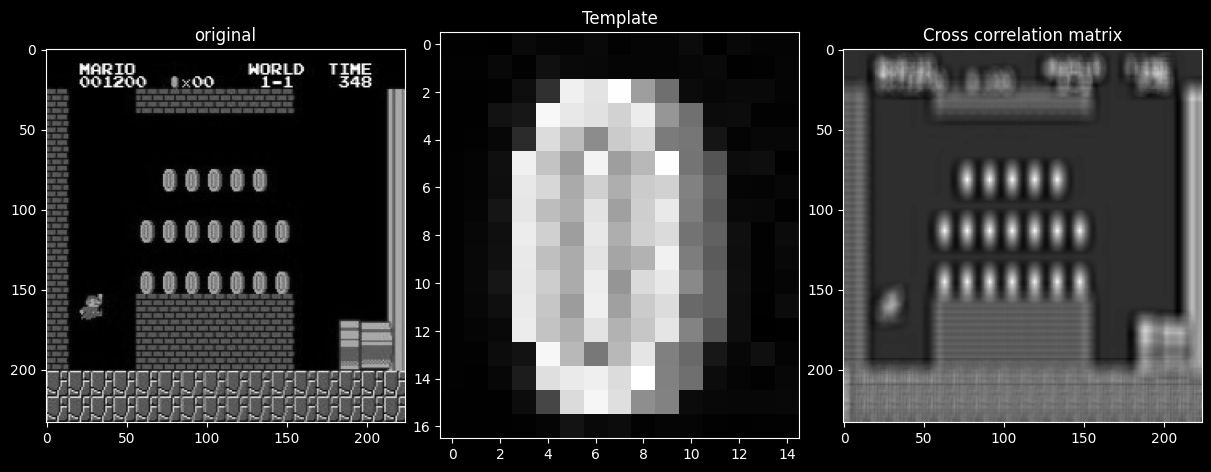

In [92]:
pa = np.array(Image.open('img/mario.jpeg').convert("L"))

pa=pa-np.mean(pa)

axs = (plt.figure(constrained_layout=True,figsize=(1000//80,1000//80))
       .subplots(1, 3, sharex=False, sharey=False))

axs[0].imshow(pa,cmap="gray")
axs[0].set_title('original')
zone_interet=np.copy(pa[73:90,70:85])
axs[1].imshow(zone_interet,cmap="gray")
axs[1].set_title('Template')

corr=signal.correlate2d(pa,zone_interet,boundary='symm', mode='same')
axs[2].imshow(corr,cmap="gray")
axs[2].set_title('Cross correlation matrix')



Text(0.5, 1.0, 'Matched Templates')

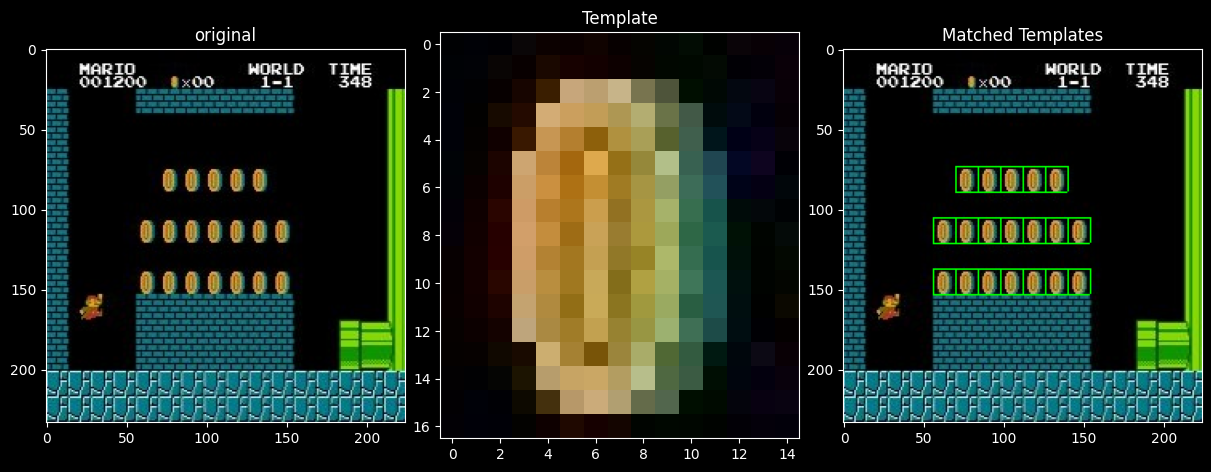

In [106]:
original = np.array(Image.open('img/mario.jpeg'))
color_template=np.copy(original[73:90,70:85])
axs = (plt.figure(constrained_layout=True,figsize=(1000//80,1000//80))
       .subplots(1, 3, sharex=False, sharey=False))

h=int((zone_interet.shape[0]-1)/2.0)
v=int((zone_interet.shape[1]-1)/2.0)



mat_corr_post=np.where(corr>1.1e6,1,0)


for i in range(0,corr.shape[0]):
    for j in range(0,corr.shape[1]):
       if mat_corr_post[i,j]>0:
              
              original[i-h:i-h+1,j-v:j+v]=np.array([0,255,0])
              original[i-h:i+h,j-v:j-v+1]=np.array([0,255,0])
              original[i+h:i+h+1,j-v:j+v]=np.array([0,255,0])
              original[i-h:i+h,j+v:j+v+1]=np.array([0,255,0])



axs[0].imshow(np.array(Image.open('img/mario.jpeg')),cmap="gray")
axs[0].set_title('original')

axs[1].imshow(color_template)
axs[1].set_title('Template')

axs[2].imshow(original)
axs[2].set_title('Matched Templates')

# Utilitaires

In [88]:
nb_images=32

w,h=400,400

for i in range(1,nb_images,2):

    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(singe,cmap="gray")
    ax.set_title("original")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(conv2(singe,np.ones((i,i))),cmap="gray")
    ax.set_title("mean filter : ("+str(i)+"x"+str(i)+")")   
    
    

    

    plt.savefig('gen_gif_'+str(i)+'.png')
    plt.close()

/var/folders/7t/84clpkws78x2jhnt808jfvz00000gn/T/ipykernel_38561/1888492380.py:12: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(conv2(singe,np.ones((i,i))),cmap="gray")
/var/folders/7t/84clpkws78x2jhnt808jfvz00000gn/T/ipykernel_38561/1888492380.py:12: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.imshow(conv2(singe,np.ones((i,i))),cmap="gray")


In [ ]:
nb_images=32

w,h=400,400

for i in range(1,nb_images,2):

    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(singe,cmap="gray")
    ax.set_title("original")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(conv2(singe,np.ones((i,i))),cmap="gray")
    ax.set_title("mean filter : ("+str(i)+"x"+str(i)+")")   
    
    

    

    plt.savefig('gen_gif_'+str(i)+'.png')
    plt.close()

ValueError: negative dimensions are not allowed

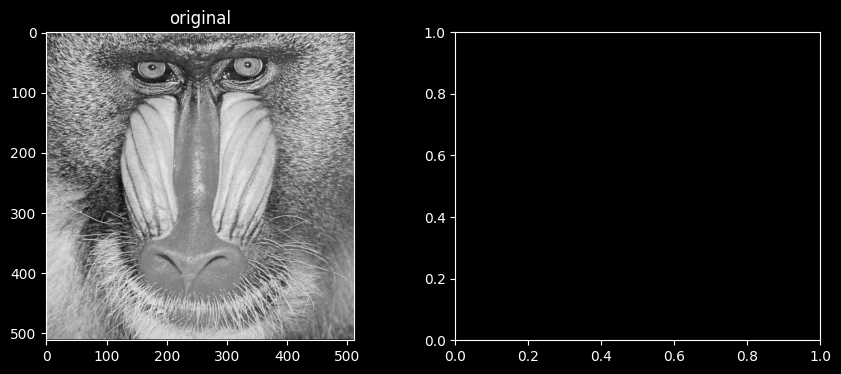

In [59]:
nb_images_u=32

w,h=400,400
tmp_arru=np.linspace(0,32,nb_images_u)

for i in range(1,nb_images_u,1):
    

    filtered_pic = conv2(singe.copy(),gaussianKernel(tmp_arru[i]))
    fig = plt.figure(figsize=plt.figaspect(0.25))
        
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(singe,cmap="gray")
    ax.set_title("original")
        
    ax = fig.add_subplot(1, 3, 2)
    F=np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(imagePad(gaussianKernel(tmp_arru[i]),np.zeros((256-int(tmp_arru[i]*10),256-int(tmp_arru[i]*10))))))))
    ax.imshow(F,cmap="gray")
    ax.set_title('filter size: '+str(gaussianKernel(tmp_arru[i]).shape))
        
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(filtered_pic,cmap="gray")
    ax.set_title('filtered image')
    


    plt.savefig('gen_gif_'+str(i)+'.png')
    plt.close()

In [60]:
nom_gif="gaussian.gif"


with imageio.get_writer(nom_gif, mode='I') as writer:
    for i in range(1,25,1):
        image = imageio.v2.imread('gen_gif_'+str(i)+'.png')
        writer.append_data(image)

for i in range(1,25,1):
    os.remove('gen_gif_'+str(i)+'.png') 

In [61]:
display_gif(nom_gif)